In [390]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

In [391]:
# Creating the method for creating the data.

def create_nomrmal_cheb_data(length: int, model_error: float = 0.1, time_series_function: callable = lambda x: x, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''
    
    minv, maxv = var_range

    true_variance_array = np.random.uniform(minv, maxv, length)
    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + np.random.uniform(model_error*minv, model_error*maxv, length)
    time_series_normal = time_series_function(corresponding_normal)

    return model_variance_array, time_series_normal


Now we will develop the method for conditional quantile estimation. We need to do the following steps:
- Have a pinball loss function.
- Have a dataset loss function. This is what we will minimize, so it needs to have accsess to the dataset.
    - It should be given the dataset which it is calculaitng for. We will not attempt anything fancy in terms of weighting. 
- Use Scipy to minimize the overall loss, which will give us the two parameters. 

We need to ensure:
- The constant term is not below zero. 

In [392]:
dataset = create_nomrmal_cheb_data(1000, model_error=0.5, time_series_function=lambda x: np.cumsum(x), var_range=(0.5, 2))

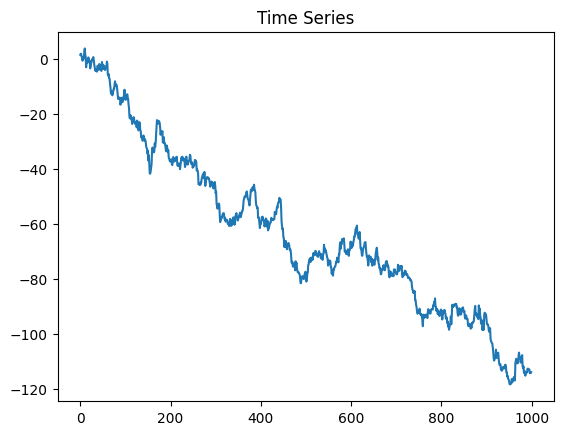

In [393]:
plt.plot(dataset[1])
plt.title('Time Series')
plt.show()

In [394]:
# Here we have the pinball loss function.

def quantile_loss(target, x): # B is target, theta is prediciton.
    '''The target is 0.1 corresponding to target of 0.9.'''
    if x >= 0:
        return (1-target)*x
    else:
        return -target*x


In [395]:
def b_conditional_quantile(lambda_const: float, lambda_var: float, target, dataset: list[tuple]):
    ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

    # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
    
    zipped_data_set = zip(*dataset) # We have to arrays of the same length. We need to have them as pairs.
    loss_list = [quantile_loss(target, y - (lambda_const + lambda_var * var)) for var, y in zipped_data_set]

    return sum(loss_list)

In [396]:
def conditional_quantile(lambda_const: float, lambda_var: float, target, dataset: list[tuple]):
    ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

    # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
    zipped_data_set = zip(dataset[0][1:], np.diff(dataset[1])[1:]) # We have to arrays of the same length. We need to have them as pairs.
    loss_list = [quantile_loss(target, y - (lambda_const + lambda_var * var)) for var, y in zipped_data_set]

    return sum(loss_list)

In [397]:
print(conditional_quantile(0.1, 0.1, 0.1, dataset))

351.42441577544696


In [398]:
from scipy.optimize import minimize

# Define the target value
target = 0.1

# Define the initial guess for lambda_const and lambda_var
initial_guess = [0.1, 0]

# Define the bounds for lambda_const and lambda_var
bounds = [(0, None), (None, None)]

# Define the function to minimize
def loss_function(params):
    lambda_const, lambda_var = params
    return conditional_quantile(lambda_const, lambda_var, target, dataset)

# Minimize the loss function
result = minimize(loss_function, initial_guess, bounds=bounds)

# Get the optimized values for lambda_const and lambda_var
lambda_const_opt, lambda_var_opt = result.x

# Print the optimized values
print("Optimized lambda_const:", lambda_const_opt)
print("Optimized lambda_var:", lambda_var_opt)

Optimized lambda_const: 1.5778918862083307
Optimized lambda_var: -0.08364443310406253


In [399]:
def find_params(target, dataset):
    '''This function will find the optimal values for lambda_const and lambda_var given the target and dataset.'''
    
    # Define the initial guess for lambda_const and lambda_var
    initial_guess = [0.1, 0]

    # Define the bounds for lambda_const and lambda_var
    bounds = [(None, None), (None, None)]

    # Define the function to minimize
    def loss_function(params):
        lambda_const, lambda_var = params
        return conditional_quantile(lambda_const, lambda_var, target, dataset)

    # Minimize the loss function
    result = minimize(loss_function, initial_guess, bounds=bounds)

    # Get the optimized values for lambda_const and lambda_var
    lambda_const_opt, lambda_var_opt = result.x

    return lambda_const_opt, lambda_var_opt

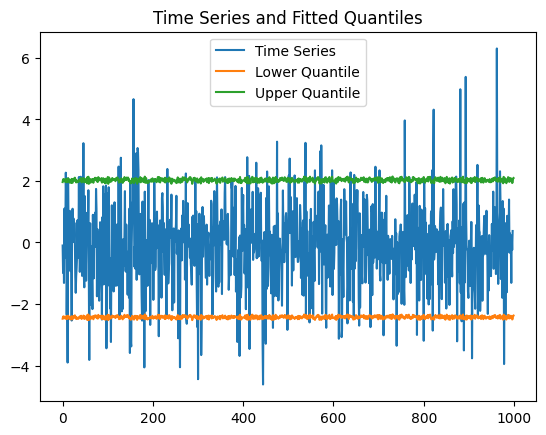

In [400]:
lower_params = find_params(0.95, dataset)
upper_params = find_params(0.05, dataset)

lower_fitted_quantile = [lower_params[0] + lower_params[1] * var for var in dataset[0]]
upper_fitted_quantile = [upper_params[0] + upper_params[1] * var for var in dataset[0]]

plt.plot(np.diff(dataset[1])[1:], label='Time Series')
plt.plot(lower_fitted_quantile, label='Lower Quantile')
plt.plot(upper_fitted_quantile, label='Upper Quantile')
plt.legend()
plt.title('Time Series and Fitted Quantiles')   
plt.show()


Why is the lower quartile more dependent on variance?
- This was because the constant term was not allowed to be negative, you need to have different condtions for what you are predicting.

In [401]:
# Ensuring that they have been fitted properly.
returns = np.diff(dataset[1])
print(np.mean(returns > upper_fitted_quantile[1:]))    
print(np.mean(returns < lower_fitted_quantile[1:]))


0.05105105105105105
0.04804804804804805


## Thoughts for production method. 
- You should use the last set of parameters for the intial guess.
- You should use the last 500 datapoints for the calibration.

What method should you make?
- Have a method which returns the parameters.
- have a static method which is the pinball loss function. You should really be using the function l. create a version which uses this. You do not want many functions inside of your class which have the same purpose.

In [410]:
def pinball_loss_function(target, y, y_hat):
        return (target * (y - y_hat)) - min(0, (y - y_hat))

# Only function which requires adding. There is no danger in making this a method function. Acctulaly it will prob be having it 
# as a method function.
def conditional_quantile_loss(params: list, target: float, dataset: list[tuple]):
    ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

    # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
    zipped_data_set = zip(dataset[0][1:], np.diff(dataset[1])[1:]) # We have to arrays of the same length. We need to have them as pairs.
    loss_list = [pinball_loss_function(target, y, (params[0] + params[1] * var)) for var, y in zipped_data_set]

    return sum(loss_list)

def find_params(target, dataset):
    '''This function will find the optimal values for lambda_const and lambda_var given the target and dataset.'''
    
    initial_guess = [0.1, 0]

    # Define the bounds for lambda_const and lambda_var
    bounds = [(None, None), (None, None)]

    # Minimize the loss function
    result = minimize(conditional_quantile_loss, initial_guess, bounds=bounds, args=(target, dataset))

    # Get the optimized values for lambda_const and lambda_var
    lambda_const_opt, lambda_var_opt = result.x

    return lambda_const_opt, lambda_var_opt


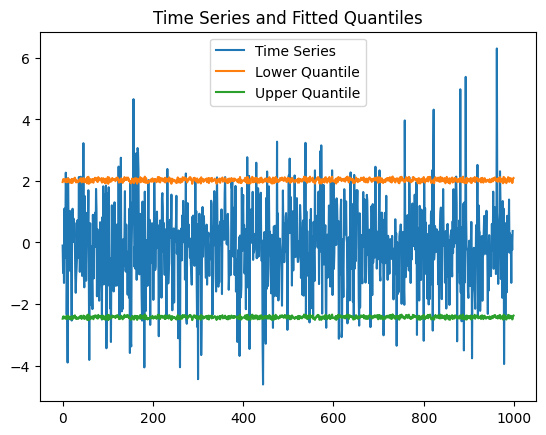

In [412]:
lower_params = find_params(0.95, dataset)
upper_params = find_params(0.05, dataset)

lower_fitted_quantile = [lower_params[0] + lower_params[1] * var for var in dataset[0]]
upper_fitted_quantile = [upper_params[0] + upper_params[1] * var for var in dataset[0]]

plt.plot(np.diff(dataset[1])[1:], label='Time Series')
plt.plot(lower_fitted_quantile, label='Lower Quantile')
plt.plot(upper_fitted_quantile, label='Upper Quantile')
plt.legend()
plt.title('Time Series and Fitted Quantiles')   
plt.show()
